## Solving the Cat Problem

This notebook tackles the *Cat Problem* from a probabilistic point of view. Modeling and proposed methods are supported by the python PyAgrum library [1], which is dedicated to Bayesian Networks computation. The goal of this approach is to show how the logical solution (as detailed in [2]) can be found using probabilistic reasoning.

#### Rules
A system with _n_ aligned boxes is considered, one of them containing a cat.
Each turn, one box can be opened to look for the cat: if it's there, the game is won; if it's not, the cat move to an adjacent box. The game is played until the sly animal is found.

#### Solution
This game has a solution, meaning that it is possible to always find the cat in a finite number of tries. Basically, given *n* boxes (from *1* to *n*), searching the cat using the sequence *2*->*3*->...*n-1*->*n-1*->*n-2*->...->*2* garanties to find the cat in a number of tries between 1 and (*n-2)*\*2. The main idea is that the first sequence allows to find the cat if it started in boxes with even numbers; once all possibilities for even boxes have been exhausted, the return path allows to search for cats that started in boxes with odd numbers.

In this notebook, we can see that this approach is equivalent to look for solutions that reduces most of the probabilities to zero (_i.e._, which exhausts most of the possible boxes).

#### Results
Different methods are presented and compared, all based on probabilistic reasoning. Two of them present the best results:
- **NaiveMethod**, which opens boxes where the cat is the most likely to be
- **EliminationMethod**, which opens boxes in order to decrease the possible number of boxes where the cat could be.

While **NaiveMethod** usely succeeds in fewer tries, **EliminationMethod** has a definite number of possible tries before finding the cat ( _(n-2)*2_ in the worst case scenario).

[1] https://pyagrum.readthedocs.io/en/1.9.0/

[2] https://mindyourdecisions.com/blog/2017/07/09/can-you-solve-the-hiding-cat-puzzle-tech-interview-question/

In [1]:
import pyAgrum as gum
import pyAgrum.lib.notebook as gnb
import pyAgrum.lib.dynamicBN as gdyn

import numpy as np
import numpy.random as rd

from visualMarkovCat import *

import pandas as pd

The number of boxes is fixed for the rest of the notebook (*min = 2*).

In [2]:
n_boxes = 10

### 1. Modelisation

The problem is represented as a Markov process. A single variable represent the boxes, and its value indicates the cat's box's number.

Using PyAgrum, this is done in two times:

(1) First a generic system is defined in order to represent the passage from one step to another

(2) The system is instanciated given a number of time steps _T_

#### 1.1 Structure Definition

In order for the system to be usable by PyAgrum for dynamic reasonning, it needs to differenciate step 0 (the initialization at time _t_) and step t (the evolution at time _t+1_). Since Markov systems are only dependant of the previous state, this is enough for the considered problem (the cat future position only depends of its current position).

In [3]:
def buildStructure( n_boxes ):
    """
    Return:
    - system: a BN composed of two states representing times _t_ and _t+1_
    - all_boxes: cosmetic list of labels to name the boxes
    """
    # Structure
    all_boxes = [f'b_{n}' for n in range(n_boxes)]
    system = gum.fastBN( f"Position0{{{'|'.join( all_boxes )}}}->Positiont{{{'|'.join( all_boxes )}}}" )
    
    # CPT
    system.cpt("Position0").fillWith(1).normalizeAsCPT()

    for n in range(n_boxes):
        nextPos = set(range(n_boxes)).intersection(set([n-1,n+1]))
        system.cpt("Positiont")[{"Position0":f"b_{n}"}] = [ 1 if i in nextPos else 0 for i in range(n_boxes) ]
    system.cpt("Positiont").normalizeAsCPT()
    
    return system, all_boxes

Using PyAgrum, system can be visualized as well as its tables of conditionnal probabilities.
**Position0** represents the initialization (all boxes are by default equiprobable), **Positiont** the possible moves the cat can take.

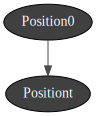

In [4]:
system, all_boxes = buildStructure( n_boxes )

gnb.show(system)
gnb.sideBySide( *[system.cpt(v) for v in sorted(system.names())] )

#### 1.2. Adding Time
PyAgrum allows to develop simple structures to simulate a complete dynamic system over a given number of time steps *T*.

In [5]:
T = 10

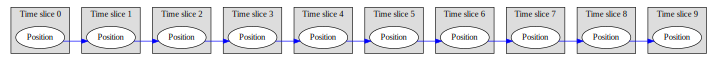

In [6]:
mc = gdyn.unroll2TBN(system, T)
gdyn.showTimeSlices(mc, size="10")

This structure can be used to compute the probable location of the cat given information.

For instance, if the cat initial position is known to be in *b\_0* (the first box):

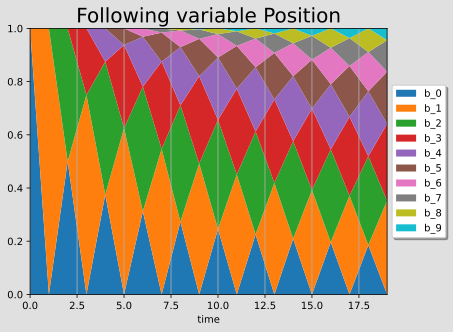

In [7]:
gdyn.plotFollow(["Position"], system, T=20, evs={"Position0":"b_0"})

Each time step gives the different states and their probabilities of happenstance. The more time passes, the less the cat's position is known.

### 2. Finding the Cat

From now on the goal is to see whether this problem can be solved using probabilistic reasoning. In this section, different methods are proposed:

- **RandomMethod**: Each turn, a random box is opened without taking into acount previous information. Thus, the probability of finding the cat is always 1/(*n_boxes*).
- **NaiveMethod**: Each turn, the player considers the previous known position of the cat to compute its next most probable position (for instance, if the cat was not in *box_1* at time *t*, it cannot be by definition in *box_0* at time *t+1*). If multiple solutions are possible, a box is chosen randomly among those.

While this last method usually brings good results, two variations are proposed to separate equiprobable boxes other than by chance:

- **EntropyMethod**: Each turn, the player opens the box that have the highest probabiliy. In case of equiprobability, the player opens the box that minimizes the system entropy (_i.e_ that favors states where there is more certainty about the cat's position).
- **HighestProbaMethod**: Each turn, the player opens the box that have the highest probabiliy. In case of equiprobability, he chooses the one that allows to maximize the probability of the cat at time T+2 if not found at this time.

On another hand, the next proposed approach do not consider the probability of being of the cat, but instead the number of boxes eliminated (*i.e.*, the probability of the cat being in it is zero).

- **EliminationMethod**: Each turn, the player chooses the solution that eliminates the most of the boxes (_i.e._ P=0). In case of egality, then it looks one step further to keep the most option removed.

#### 2.1. Methods

Methods all take as input three variables:

- *evs*: The true position of the cat each time
- *trace*: The choices made by the player
- *all_boxes*: List of the boxes names

Then they compute the player's next move.

In [8]:
def RandomMethod(evs, trace, all_boxes):
    """
    Propose a random box each time.
    """
    return( rd.choice( all_boxes ) )

In [9]:
def NaiveMethod(evs, trace, all_boxes):
    """
    Propose the next most probable box knowing the past tries.
    """
    T = len(trace)
    mc = gdyn.unroll2TBN(system, T+1)
    
    # Create an evidence from the trace: "I know the cat was not here"
    evs_tr = dict()
    for t in range(len(trace)):
        evs_tr[ f"Position{t}" ] = [ 1 if all_boxes[k]!=trace[t] else 0 for k in range(len(all_boxes)) ]
    
    # Compute the inference knowing past tries
    ie = gum.LazyPropagation(mc)
    ie.setEvidence(evs_tr)
    ie.makeInference()
    
    # Get all boxes with the highest probability
    argmax = ie.posterior( f"Position{T}" ).argmax()
    
    # Get all boxes with the highest probability
    possibleBoxes = [ all_boxes[ u[f"Position{T}"] ] for u in argmax[0] ]
    
    return( rd.choice( possibleBoxes ) )

In [10]:
def EntropyMethod(evs, trace, all_boxes):
    """
    In case of equiprobability, compute the entropy for each possibility
    """
    T = len(trace)
    mc = gdyn.unroll2TBN(system, T+2)
    
    # Create an evidence from the trace: "I know the cat was not here"
    evs_tr = dict()
    for t in range(len(trace)):
        evs_tr[ f"Position{t}" ] = [ 1 if all_boxes[k]!=trace[t] else 0 for k in range(len(all_boxes)) ]
    
    # Compute the inference knowing past tries
    ie = gum.LazyPropagation(mc)
    ie.setEvidence(evs_tr)
    ie.makeInference()
    
    # Get all boxes with the highest probability
    argmax = ie.posterior( f"Position{T}" ).argmax()
    possibleBoxes = [ all_boxes[ u[f"Position{T}"] ] for u in argmax[0] ]
    
    # Compute the entropy for each remaining possibility
    if len( possibleBoxes ) > 1:
        d_entropy = dict()
        for b in possibleBoxes:
            evs_tr[ f"Position{T}" ] = [ 1 if all_boxes[k]!=b else 0 for k in range(len(all_boxes)) ]

            # Compute the inference knowing past tries
            try:
                ie = gum.LazyPropagation(mc)
                ie.setEvidence(evs_tr)
                ie.makeInference()

                d_entropy[ b ] = ie.posterior( f"Position{T+1}" ).entropy()

            except:
                d_entropy[ b ] = float('inf')

        # Get all boxes with the lowest entropy
        possibleBoxes = [ b for b in possibleBoxes if d_entropy[b] == min(d_entropy.values()) ]
    
    return( rd.choice( possibleBoxes ) )

In [11]:
def HighestProbaMethod(evs, trace, all_boxes):
    """
    If case of equiprobability, choose the case that leads to the highest proba
    """
    T = len(trace)
    mc = gdyn.unroll2TBN(system, T+2)
    
    # Create an evidence from the trace: "I know the cat was not here"
    evs_tr = dict()
    for t in range(len(trace)):
        evs_tr[ f"Position{t}" ] = [ 1 if all_boxes[k]!=trace[t] else 0 for k in range(len(all_boxes)) ]
    
    # Compute the inference knowing past tries
    ie = gum.LazyPropagation(mc)
    ie.setEvidence(evs_tr)
    ie.makeInference()
    
    # Get all boxes with the highest probability
    argmax = ie.posterior( f"Position{T}" ).argmax()
    possibleBoxes = [ all_boxes[ u[f"Position{T}"] ] for u in argmax[0] ]
    
    # Compute the entropy for each remaining possibility
    if len( possibleBoxes ) > 1:
        d_highest = dict()
        for b in possibleBoxes:
            evs_tr[ f"Position{T}" ] = [ 1 if all_boxes[k]!=b else 0 for k in range(len(all_boxes)) ]

            # Compute the inference knowing past tries
            try:
                ie = gum.LazyPropagation(mc)
                ie.setEvidence(evs_tr)
                ie.makeInference()

                d_highest[ b ] = ie.posterior( f"Position{T+1}" ).max()

            except:
                d_highest[ b ] = 0

        # Get all boxes with the lowest entropy
        possibleBoxes = [ b for b in possibleBoxes if d_highest[b] == max(d_highest.values()) ]
    
    return( rd.choice( possibleBoxes ) )

In [12]:
def EliminationMethod(evs, trace, all_boxes):
    """
    For each turn, choose a solution that allows to eliminate the most boxes
    """
    T = len(trace)
    mc = gdyn.unroll2TBN(system, T+3)
    
    # Create an evidence from the trace: "I know the cat was not here"
    evs_tr = dict()
    for t in range(len(trace)):
        evs_tr[ f"Position{t}" ] = [ 1 if all_boxes[k]!=trace[t] else 0 for k in range(len(all_boxes)) ]
        
    # Check if the cat position is certain
    ie = gum.LazyPropagation(mc)
    ie.setEvidence(evs_tr)
    ie.makeInference()

    ind_1 = ie.posterior( f"Position{T}" ).findAll(1)
    if len( ind_1 ) == 1:
        return( all_boxes[ ind_1[0][f"Position{T}"] ] )

    else:
        # Compute the probabilities for each remaining possibility
        d_postT = dict()
        maxZeroT = 0
        maxZeroT1 = 0
        
        for b in all_boxes:
            evs_tr[ f"Position{T}" ] = [ 1 if all_boxes[k]!=b else 0 for k in range(len(all_boxes)) ]

            # Compute the inference knowing past tries
            try:
                ie = gum.LazyPropagation(mc)
                ie.setEvidence(evs_tr)
                ie.makeInference()

                d_postT[ b ] = ( len( ie.posterior( f"Position{T+1}" ).findAll(0) ),
                                 len( ie.posterior( f"Position{T+2}" ).findAll(0) ) )
                
                if d_postT[ b ][0] > maxZeroT:
                    maxZeroT = d_postT[ b ][0]
                if d_postT[ b ][1] > maxZeroT1:
                    maxZeroT1 = d_postT[ b ][1]

            except:
                d_postT[ b ] = (0,0)

        # Get all boxes which help clear possibilities
        possibleBoxes = [ b for b in all_boxes if d_postT[b][0] == maxZeroT ]
        
        # If still not selected, look the time after
        if len(possibleBoxes) > 1:

            # Get all boxes which help clear possibilities
            possibleBoxes = [ b for b in possibleBoxes if d_postT[b][1] == maxZeroT1 ]

        return( rd.choice( possibleBoxes ) )

### 2.2 Game Modeling

Each game is coded the same way: given a initial position of the cat (which can be randomized) and a search method, a game is played until either the cat is found or a given limit is obtained (which can be necessary with certain methods such as *RandomMethod*, as there is no garanty the cat can be found in a reasonnable number of tries... Even with only two boxes!

In [13]:
def moveCat(current, all_boxes):
    """
    Move the cat knowing its current box.
    """
    cpt = system.cpt("Positiont")[ {"Position0":current} ]
    return( rd.choice( all_boxes, p=cpt ) )

In [14]:
def Run( method, all_boxes, init = "b_0", first_guess=None, limit = 1000, seed = None ):
    """
    Run a game using a give method.
    """
    if seed != None:
        rd.seed(seed)
    
    T = 0
    
    # Cat start
    if init == None:
        current = rd.choice(all_boxes)
    else:
        current = init
        
    evs = { "Position0":current }
    
    # First Guess
    if first_guess == None:
        guess = method(evs, [], all_boxes)
    else:
        guess = first_guess
    trace = np.array([guess])
    
    while current != guess and T < limit:
        T += 1
        # Move Cat
        current = moveCat(current, all_boxes)
        evs[ f"Position{T}" ] = current
        
        # Next Guess
        guess = method(evs, trace, all_boxes)
        trace = np.append( trace, guess )
        
    return( current==guess, method, evs, trace )

### 3. Simulations

Using this code, we can simulate runs for the different methods.

For the sake of readability, vizualization functions are included in a joint script.

Cat position is indicated by a smiley and a clack box highligt; Player's choice is indicated by a blue dotted highlight. 
#### 1. Example: **NaiveMethod**

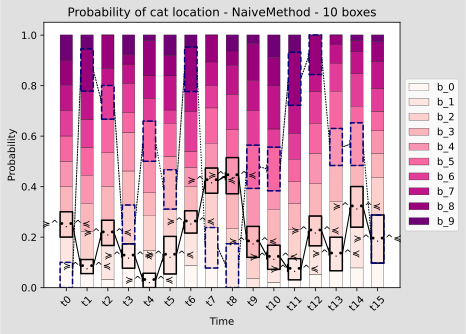

In [15]:
guess, method, evs, trace = Run( NaiveMethod, all_boxes, first_guess=None, init = None, seed = 13 )
Trace(evs, trace, method, n_boxes, all_boxes, system)

#### 2. Example: HighestProbaMethod

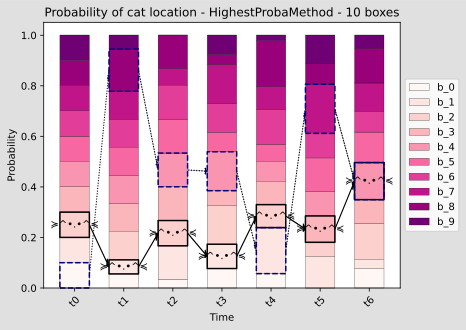

In [16]:
guess, method, evs, trace = Run( HighestProbaMethod, all_boxes, first_guess=None, init = None, seed = 13 )
Trace(evs, trace, method, n_boxes, all_boxes, system)

#### 3. Example: **EliminationMethod**

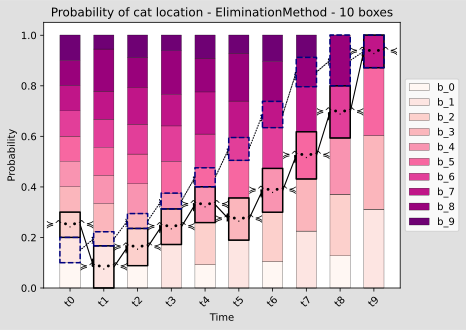

In [17]:
guess, method, evs, trace = Run( EliminationMethod, all_boxes, first_guess=None, init = None, seed = 13 )
Trace(evs, trace, method, n_boxes, all_boxes, system)

As introduced, **EliminationMethod** follows the same behaviour as the logical solution: it starts at boxes *2*/*n-1*, then goes throught all boxes until *n-1*/*2* and take the backward path.

### 4. Evaluation

Evaluation allows to play multiple games to assess the average number of tries required before finding the cat.

This allows to compare the different solutions and see how they fare.

The output graph represents all the number of tries, as well as the average and the Confidence Interval at 95%.

In [18]:
def Evaluation(method, all_boxes, nb= 150, init = None, first_guess=None, limit = 1000):
    """
    Run a game multiple times and return all the results.
    """
    numberTry = np.array([])
    results = { "found":np.array([]),
                "method":np.array([]),
                "evs":np.array([]),
                "trace":[]
              }
    
    for i in range(nb):    
        found, method, evs, trace = Run(method, all_boxes, init, first_guess, limit)
        
        results["found"] = np.append( results["found"], found )
        results["method"] = np.append( results["method"], method )
        results["evs"] = np.append( results["evs"], evs )
        results["trace"].append( trace )
        
        if found:
            numberTry = np.append( numberTry, len(evs) )
        else:
            numberTry = np.append( numberTry, np.nan )
            
    return( numberTry, results )

def multipleEvaluations(l_method, all_boxes, nb=100, init=None, limit=100):
    """
    Run multiple games to evaluate the performances.
    """
    results = dict()
    for m in l_method:
        results[ m.__name__ ], r = Evaluation(m, all_boxes, nb, init, limit=limit)
        
    return results

In [19]:
l_method = [RandomMethod, NaiveMethod, EntropyMethod, HighestProbaMethod, EliminationMethod]

#### 4.1. Comparaison of the methods with random cat initialization

We suppose in this run that the cat's initial position is not fixed.

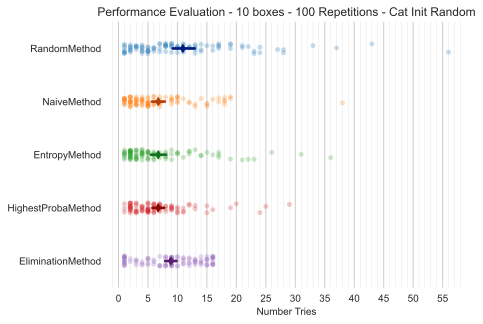

In [20]:
results = multipleEvaluations(l_method, all_boxes, nb=100)
traceEvaluation(results, n_boxes)

**NaiveMethod** usually obtains better results, meaning that the average number of tries is lower than for each other method. Depending of the initial conditions, **EntropyMethod** and **HighestProbaMethod** can do better. However, **EliminationMethod** is the solution with the lowest *worst* number of tries.

#### 4.2. Impact of the Starting Positions

Comparaison of the number of tries required when the cat starts at one extremity or in the middle.

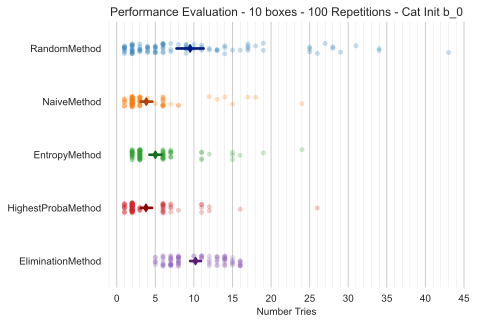

In [21]:
results = multipleEvaluations(l_method, all_boxes, nb=100, init=f"b_0", limit=100)
traceEvaluation(results, n_boxes, init=f"b_0")

In this case, naive methods are advantaged, as they usually favors the extremities of the boxes line. **EliminationMethod** on another hand is not the most adapted to this configuration, as it first starts looking for cats spawning in *even* boxes.

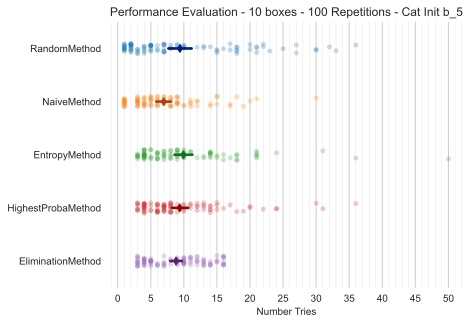

In [22]:
results = multipleEvaluations(l_method, all_boxes, nb=100, init=f"b_{int(n_boxes/2)}", limit=100)
traceEvaluation(results, n_boxes, init=f"b_{int(n_boxes/2)}")

This case is less at the advantage of the naive methods. However, they continue to do better than the **EliminationMethod** in term of average number of tries.

#### 4.3 Impact of number of boxes

<Axes: xlabel='Nb_Boxes', ylabel='Number of Tries'>

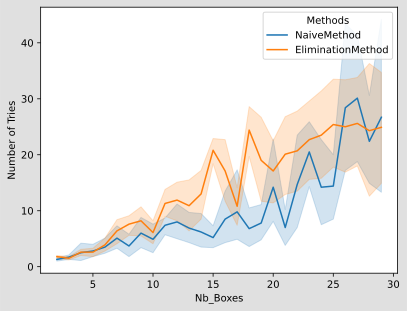

In [23]:
l_method = [NaiveMethod, EliminationMethod]

df = pd.DataFrame()

for n in range(2,30):
    system, all_boxes = buildStructure( n )
    results = multipleEvaluations(l_method, all_boxes, nb=10, limit=100)
    df_results = pd.DataFrame( results )
    df_results["Nb_Boxes"] = n

    df = pd.concat( [df, df_results], ignore_index=True )
    
df = pd.melt(df, id_vars = "Nb_Boxes", value_vars=results.keys(), 
             var_name='Methods', value_name='Number of Tries')
            
sns.lineplot(data=df, x="Nb_Boxes", y="Number of Tries", hue="Methods")